In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from sklearn.metrics import accuracy_score

In [2]:
#load data and ensure there are no na in dataset
train = pd.read_csv('./training.csv')

train.isna().any()

text     False
label    False
dtype: bool

In [3]:
#Perform oversampling and undersampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

print("Before undersampling:", Counter(train['label']))

class_counts = Counter(train['label'])

# Set the target number of samples per class
target_samples = 3000

# Determine classes needing oversampling and undersampling
classes_to_resample = {cls: target_samples for cls, count in class_counts.items() if count < target_samples}
classes_to_keep = {cls: target_samples for cls, count in class_counts.items() if count >= target_samples}
print('Class to OverSample: ', classes_to_resample)
print("Class to UnderSample: ", classes_to_keep)
# Oversample minority classes
oversampler = RandomOverSampler(sampling_strategy=classes_to_resample)

# Undersample majority classes
undersampler = RandomUnderSampler(sampling_strategy=classes_to_keep)


train_text_resampled, train_labels_resampled = oversampler.fit_resample(np.array(train['text']).reshape(-1,1), train['label'])

print('After Oversample:' , Counter(train_labels_resampled))

train_text_resampled, train_labels_resampled = undersampler.fit_resample(train_text_resampled, train_labels_resampled)

# Check the class distribution after resampling
print('After Undersample:', Counter(train_labels_resampled))

Before undersampling: Counter({1: 5362, 0: 4666, 3: 2159, 4: 1937, 2: 1304, 5: 572})
Class to OverSample:  {3: 3000, 2: 3000, 5: 3000, 4: 3000}
Class to UnderSample:  {0: 3000, 1: 3000}
After Oversample: Counter({1: 5362, 0: 4666, 3: 3000, 2: 3000, 5: 3000, 4: 3000})
After Undersample: Counter({0: 3000, 1: 3000, 2: 3000, 3: 3000, 4: 3000, 5: 3000})


In [4]:
#split data to train, validation, and test sets
from sklearn.model_selection import train_test_split
train_labels_resampled = np.array(train_labels_resampled)
X_train, X_temp, y_train, y_temp = train_test_split(train_text_resampled,train_labels_resampled,test_size=0.3,random_state=42)
X_val, X_test, y_val,y_test =  train_test_split(X_temp,y_temp,test_size=0.5, random_state=42)

In [5]:
#Convert data to accepted by the tokenizer
Demo = [sentence[0] for sentence in X_train]

In [6]:
#load tokenizer from keras
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>', split=' ', char_level=False)
tokenizer.fit_on_texts(Demo)

#Setup a class to tokenize the data
def tokenize(data):
    data = [sentence[0] for sentence in data]
    sequences = tokenizer.texts_to_sequences(data)
    padded = pad_sequences(sequences, truncating = 'post', padding='post', maxlen=50)
    return padded

In [7]:
#perform data tokenization
tokenized_data_train = tokenize(X_train)
tokenized_data_val = tokenize(X_val)
tokenized_data_test =  tokenize(X_test)

In [8]:
#Ensure the data is tokenized properly
print(tokenized_data_test)

[[  2  33 101 ...   0   0   0]
 [  2  76   5 ...   0   0   0]
 [ 17   8  18 ...   0   0   0]
 ...
 [  2  42 289 ...   0   0   0]
 [  2   3 435 ...   0   0   0]
 [  2  87   3 ...   0   0   0]]


In [9]:
#Convert Tokenized Data to desired format
train_dataset = tf.data.Dataset.from_tensor_slices((
    tokenized_data_train,
    y_train
)).shuffle(len(train['text'])).batch(32)

val_dataset = tf.data.Dataset.from_tensor_slices((
    tokenized_data_val,
    y_val
)).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((
    tokenized_data_test,
    y_test
)).batch(32)

In [10]:
#Setup Model
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(10000,32,input_length=50),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(80)),
tf.keras.layers.Dense(6, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 32)            320000    
                                                                 
 bidirectional (Bidirection  (None, 160)               72320     
 al)                                                             
                                                                 
 dense (Dense)               (None, 6)                 966       
                                                                 
Total params: 393286 (1.50 MB)
Trainable params: 393286 (1.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
# Define optimizer
optimizer = tf.keras.optimizers.AdamW(learning_rate=5e-4)

# Compile the model
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary)

# Fine-tuning
history = model.fit(train_dataset,
                    batch_size = 20,
                    epochs=30,
                    validation_data=val_dataset,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.01, patience=5)]
                    )


<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x29377fc90>>
Epoch 1/30
394/394 [==============================] - 8s 18ms/step - loss: 1.5941 - accuracy: 0.3047 - val_loss: 1.2665 - val_accuracy: 0.4759
Epoch 2/30
394/394 [==============================] - 7s 19ms/step - loss: 0.9423 - accuracy: 0.6190 - val_loss: 0.7887 - val_accuracy: 0.6630
Epoch 3/30
394/394 [==============================] - 8s 21ms/step - loss: 0.5575 - accuracy: 0.8044 - val_loss: 0.5369 - val_accuracy: 0.8296
Epoch 4/30
394/394 [==============================] - 7s 19ms/step - loss: 0.3269 - accuracy: 0.9043 - val_loss: 0.3800 - val_accuracy: 0.8807
Epoch 5/30
394/394 [==============================] - 8s 20ms/step - loss: 0.1926 - accuracy: 0.9458 - val_loss: 0.3714 - val_accuracy: 0.8848
Epoch 6/30
394/394 [==============================] - 7s 19ms/step - loss: 0.1434 - accuracy: 0.9602 - val_loss: 0.3482 - val_accuracy: 0.8989
Epoch 7/30
394/394 [===========================

In [12]:
#Evaluation
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss} Test Accuracy: {test_accuracy}')

 1/85 [..............................] - ETA: 0s - loss: 0.1246 - accuracy: 0.9688

85/85 [==============================] - 0s 4ms/step - loss: 0.4086 - accuracy: 0.8781
Test Loss: 0.4086182117462158 Test Accuracy: 0.8781481385231018


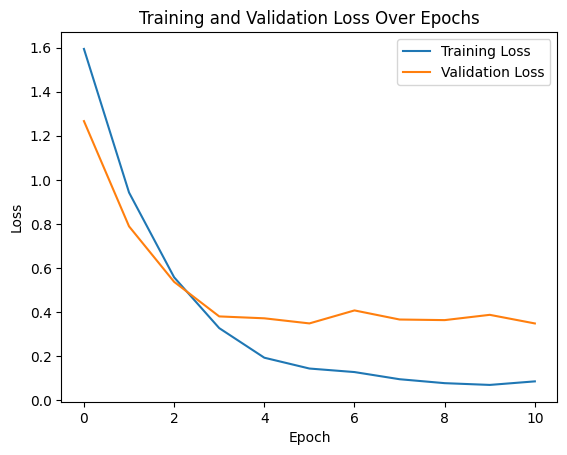

In [13]:
import matplotlib.pyplot as plt

loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

plt.plot(loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
model.save('LSTMModel.h5')

/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
